In [1]:
%load_ext autoreload
%autoreload 2
import dotenv
dotenv.load_dotenv()

True

# Load trainer

In [9]:
from experimentator import build_experiment, find

exp = build_experiment(find("../configs/ballstate.py"), load_weights=False, side_length=32)

../configs/ballstate.py found in /home/gva/repositories/deepsport/notebooks/../configs/ballstate.py
ball_states_dataset.pickle found in /scratch/gva/ball_states_dataset.pickle
ballistic_ball_views.pickle found in /scratch/gva/ballistic_ball_views.pickle


# Show dataset

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


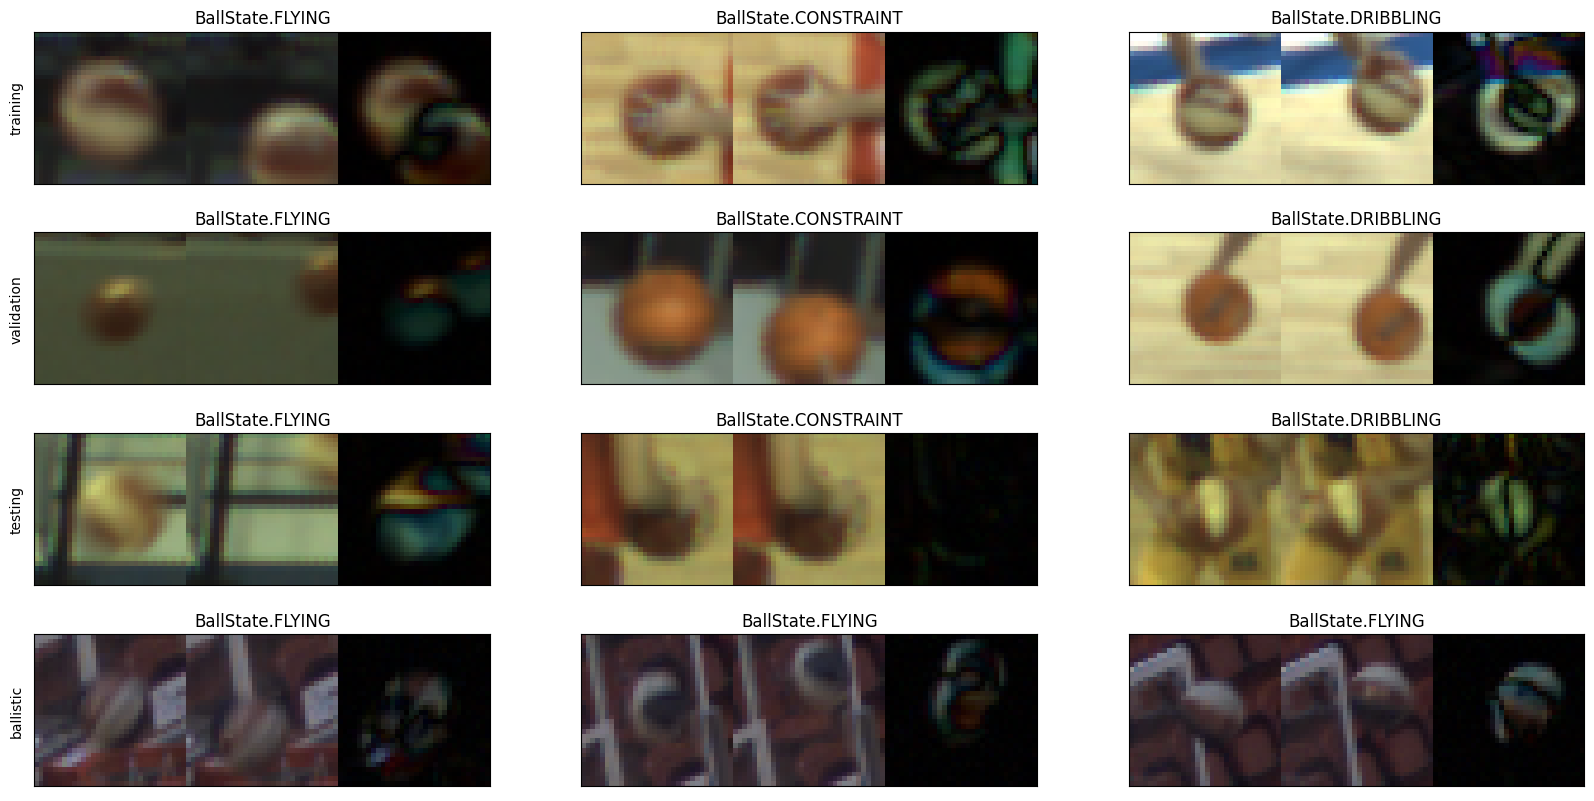

In [12]:
from matplotlib import pyplot as plt 
from dataset_utilities.ds.raw_sequences_dataset import BallState
import numpy as np

batch_size = 3 if exp.cfg['with_diff'] else 7
fig, axes = plt.subplots(len(exp.subsets), batch_size, figsize=(20,10))
for i, subset in enumerate(exp.subsets):
    batch_keys, batch = next(exp.batch_generator(subset=subset, batch_size=batch_size)) # balances batches wrt ball state
    for j, key in enumerate(batch_keys):
        if exp.cfg['with_diff']:
            diff = np.abs(batch["batch_input_image"][j].astype(np.int32) - batch["batch_input_image2"][j].astype(np.int32))
            axes[i,j].imshow(np.hstack((batch["batch_input_image"][j], batch["batch_input_image2"][j], diff)))
        else:
            axes[i,j].imshow(batch["batch_input_image"][j])
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        axes[i,j].set_title(BallState(batch['batch_ball_state'][j]))
    axes[i,0].set_ylabel(subset.name)

# Train for 10 epochs

In [11]:
exp.train(11)

epochs:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2698 [00:00<?, ?batches/s]

Initializing model with {'batch_input_image': TensorSpec(shape=(16, 32, 32, 3), dtype=tf.uint8, name=None), 'batch_input_image2': TensorSpec(shape=(16, 32, 32, 3), dtype=tf.uint8, name=None), 'batch_ball_state': TensorSpec(shape=(16,), dtype=tf.int64, name=None)}
Initializing 'tf.keras.applications.vgg16.VGG16' with input KerasTensor(type_spec=TensorSpec(shape=(16, 16, 16, 3), dtype=tf.float32, name=None), name='sequential_3/batch_normalization_3/FusedBatchNormV3:0', description="created by layer 'sequential_3'")


/home/gva/repositories/experimentator/experimentator/tf2_experiment.py:119: UserWarning: Failed calling TensorflowBackbone(model_name=vgg16.VGG16)
  warnings.warn(f"Failed calling {chunk_processor}")


ValueError: Input size must be at least 32x32; Received: input_shape=(16, 16, 3)

# Load experiment

In [ ]:
import os
from experimentator import build_experiment

experiment_id = '20221020_114726.569384' #'latest'   # update with experiment ID
folder = os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id)
exp = build_experiment(os.path.join(folder, 'config.py'))

# Load metrics

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from experimentator import DataCollector

dc = DataCollector(os.path.join(folder, "history.dcp"))
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,6))
for ax, name, metric, fct in [
    (axes[0], "Loss",             "loss",                   lambda x:x),
    (axes[1], "FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    (axes[2], "FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]:
    for subset in ["training", "validation", "ballistic"]:
        label = f"{subset}_{metric}"
        l = np.array([fct(x) if x is not None else np.nan for x in dc[label, :]])
        w = np.where(np.isfinite(l))[0]
        ax.plot(w, l[w], label=label, markersize=5, marker='.')
        ax.set_title(name, fontsize=10)
    ax.legend()
    ax.set_ylim([0,1])

In [ ]:
dc['testing_classification_metrics']['recall'].iloc[1]

In [ ]:
import seaborn as sn
from dataset_utilities.ds.raw_sequences_dataset import BallState
states = [str(BallState(i))[10:] for i in range(4)]
subsets = ['validation', 'testing', 'ballistic']
fig, axes = plt.subplots(1, len(subsets), figsize=(10, 3), sharey=True)
for subset, ax in zip(subsets, axes):
    m = [a for a in dc[f'{subset}_confusion_matrix', :] if a is not None][-1]
    ax.set_title(f"{subset} set")
    sn.heatmap(m, annot=True, ax=ax, fmt='g')
    ax.set_xlabel("predicted class")
    ax.set_xticklabels(states, rotation=90)
    ax.set_ylabel("true class")
    ax.set_yticklabels(states, rotation=0)

In [ ]:
print(type(dc['testing_confusion_matrix']))

In [ ]:
s = exp.subsets[0]
for k in s.dataset.yield_keys():
    view = s.dataset.query_item(k)
    print(view.keys())
    break

In [ ]:
s = exp.subsets[-1]
ds = s.dataset
it = exp.batch_generator(s, batch_size=4)
while True:
    batch_keys, batch_input = next(it)
    batch_output = exp.batch_eval(batch_input)
    target = np.array(batch_output['batch_target']) # one hot encoded
    output = np.array(batch_output['batch_output']) == np.max(batch_output['batch_output'], axis=1)[..., np.newaxis]
    indices = np.where(np.any(target - output, axis=1))[0]
    for i in indices:
        plt.imshow(batch_input['batch_input_image'][i])
        plt.show()
        print("predicted:", BallState(np.argmax(output[i])))

In [ ]:
print(target[0])
print(output[0])
print(target - output)
output = np.array(batch_output['batch_output']) == np.max(batch_output['batch_output'], axis=1)[..., np.newaxis]
print(output)

# Evaluation

In [ ]:
batch_size = 6
its = {subset.name: exp.batch_generator(subset, batch_size=batch_size) for subset in exp.subsets}

In [ ]:
from matplotlib import pyplot as plt
from experimentator.dataset import collate_fn

fig, axes = plt.subplots(len(exp.subsets), batch_size, figsize=(20,10))
for i, subset in enumerate(exp.subsets):
    keys, batch_input = next(its[subset.name]) # balances batches wrt ball state
    batch_output = exp.batch_eval(batch_input)
    print(batch_output['batch_output'].numpy())
    print(batch_output['batch_target'].numpy())
    for j in range(batch_size):
        ax = axes[i,j]
        ax.imshow(batch_input["batch_input_image"][j])
        ax.set_xticks([])
        ax.set_yticks([])
        true_class = str(BallState(batch_input['batch_ball_state'][j]))
        pred_class = str(BallState(np.argmax(batch_output['batch_output'][j])))
        if true_class != pred_class:
            for spine in ['bottom', 'top', 'right', 'left']:
                ax.spines[spine].set_color('red')
        ax.set_title(true_class)
        for y, text in [
            (.9, f"{true_class}"),
            (.2, f"{pred_class}"),
            (.1, f"{np.max(batch_output['batch_output'][j]):.2f}"),
        ]:
            ax.text(.05, y, text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, color='white', fontsize=12)
    axes[i,0].set_ylabel(subset.name)